# Evaluation

In this notebook we will demonstrate how to evaluate a set of generated mixes via objective metrics.

We will use the mixes generated from the [inference notebook](https://github.com/csteinmetz1/automix-toolkit/blob/main/notebooks/inference.ipynb), and we will objectively compare those mixes to the human-made groudn truth mixes.

The objective evaluation of mixes can be carried out through audio features that relate to the most common audio effects used during mixing. Since audio effects generally manipulate audio characteristics such as frequency content, dynamics, spatialization, timbre, or pitch, we can use audio features that are associated with these audio characteristics as a way to numerically evaluate mixes.

We can use the following audio features:
    
-**Spectral features** for EQ and reverberation: centroid, bandwidth, contrast, flatness, and roll-off

-**Spatialisation features** for panning: the Panning Root Mean Square (RMS)

-**Dynamic features** for dynamic range processors: RMS level, dynamic spread and crest factor

-**Loudness features**: the integrated loudness level (LUFS) and peak loudness

To capture the dynamics of audio effects information we can compute the running mean over a fixed number of past frames. We can calculate the mean absolute percentage error (MAPE) between the target and output features to get a better understanding of the overall relative error.

Note: This notebook assumes that you have already installed the `automix` package. 

In [ ]:
!pip install git+https://github.com/csteinmetz1/automix-toolkit

In [2]:
import os
import glob
import torchaudio
import numpy as np

import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

from automix.evaluation.utils_evaluation import get_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Drums mixing evaluation

We will evaluate two different trained models with a test sample from the ENST-drums subset.

Models: the Differentiable Mixing Console (DMC), and the MixWaveUNet.

In [3]:
# then download and extract a drum multitrack from the test set
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
!unzip -o drums-test-rock.zip

mix_target_path = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks.wav"
mix_auto_path_wun = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_MixWaveUNet.wav"
mix_auto_path_dmc = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_DMC.wav"

# Global Settings
SR = 44100
max_samples = 262144
start_sample = 0 * SR
end_sample = start_sample + max_samples

--2024-08-29 16:44:05--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
Resolving huggingface.co (huggingface.co)... 2600:9000:2751:be00:17:b174:6d00:93a1, 2600:9000:2751:8a00:17:b174:6d00:93a1, 2600:9000:2751:ec00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2751:be00:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/78590471160237edbabf64fc347697793a647ed287bcff367bfa577753e93b70?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27drums-test-rock.zip%3B+filename%3D%22drums-test-rock.zip%22%3B&response-content-type=application%2Fzip&Expires=1725176623&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNTE3NjYyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9lYy9lZS9lY2VlMzhkZjA0N2UzZjJkYjFiZD

## Load the mixes

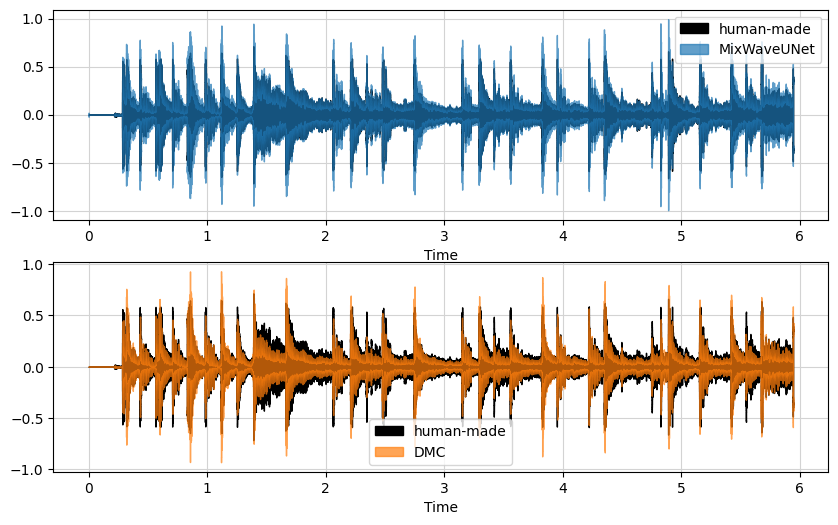

In [4]:
fig, axs = plt.subplots(2, 1)

target_audio, sr = torchaudio.load(mix_target_path)
target_audio = target_audio[:, start_sample: end_sample]

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    axis='time', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[0])

wun_audio, sr = torchaudio.load(mix_auto_path_wun)
wun_audio = wun_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    wun_audio[0,:].view(-1).numpy(), 
    axis='time', 
    sr=SR, 
    zorder=3, 
    label='MixWaveUNet', 
    color='tab:blue', 
    ax=axs[0], alpha=0.7)
axs[0].grid(c="lightgray")
axs[0].legend()

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    axis='time', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[1])

dmc_audio, sr = torchaudio.load(mix_auto_path_dmc)
dmc_audio = dmc_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    dmc_audio[0,:].view(-1).numpy(),
    axis='time',
    sr=SR,
    zorder=3,
    label='DMC', 
    color='tab:orange', 
    ax=axs[1], 
    alpha=0.7)
axs[1].grid(c="lightgray")
axs[1].legend()

## Compute the loudness, spectral, panning and dynamic features

In [5]:
target_audio = target_audio.numpy()
wun_audio = wun_audio.numpy()
dmc_audio = dmc_audio.numpy()

wun_features = get_features(target_audio, wun_audio)
dmc_features = get_features(target_audio, dmc_audio)

wun_features_mean = {k.split('_')[-1]: wun_features.pop(k) for k in list(wun_features.keys()) if k.startswith('mean_mape')}
dmc_features_mean = {k.split('_')[-1]: dmc_features.pop(k) for k in list(dmc_features.keys()) if k.startswith('mean_mape')}

## Plots averages features

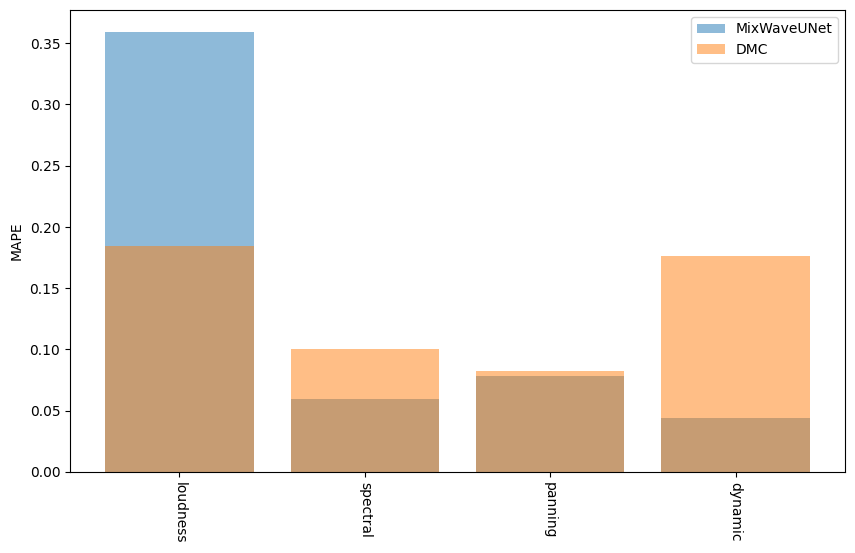

In [6]:
plt.bar(*zip(*wun_features_mean.items()), alpha=0.5, fill=True, color='tab:blue', label='MixWaveUNet')
plt.bar(*zip(*dmc_features_mean.items()), alpha=0.5, fill=True, color='tab:orange', label='DMC')
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()
plt.show()

## Plots all features

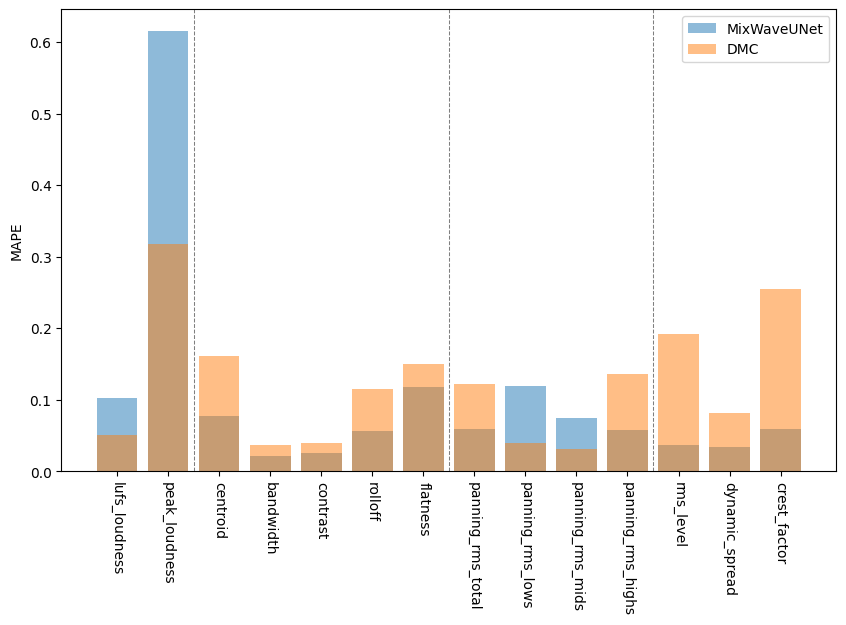

In [7]:
plt.bar(*zip(*wun_features.items()), alpha=0.5, fill=True, color='tab:blue', label='MixWaveUNet')
plt.bar(*zip(*dmc_features.items()), alpha=0.5, fill=True, color='tab:orange', label='DMC')
plt.axvline(1.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(6.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(10.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()
plt.show()